# Credit Risk Modeling - Model Training

**Dataset:** Lending Club Loan Data (Processed)

**Objective:** Train, compare, and select the best model for predicting loan default with proper handling of class imbalance.

---

## Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Baseline Model: Logistic Regression](#2-baseline-model-logistic-regression)
3. [Advanced Model: Random Forest](#3-advanced-model-random-forest)
4. [Advanced Model: XGBoost](#4-advanced-model-xgboost)
5. [Hyperparameter Tuning](#5-hyperparameter-tuning)
6. [Model Comparison](#6-model-comparison)
7. [Best Model Selection](#7-best-model-selection)
8. [Model Persistence](#8-model-persistence)
9. [Summary](#9-summary)

---
## 1. Setup & Data Loading

In [43]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib
import time

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

import time

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [44]:
# Load processed data
processed_dir = Path('../data/processed')

print("Loading processed datasets...\n")

train_df = pd.read_csv(processed_dir / 'train_data.csv')
test_df = pd.read_csv(processed_dir / 'test_data.csv')

print(f"✓ Train data loaded: {train_df.shape}")
print(f"✓ Test data loaded: {test_df.shape}")

# Load feature names
with open(processed_dir / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"\n✓ Features loaded: {len(feature_names)}")

Loading processed datasets...

✓ Train data loaded: (258553, 100)
✓ Test data loaded: (72475, 100)

✓ Features loaded: 97


In [45]:
# Prepare X and y
# Remove non-feature columns and target
cols_to_drop = ['target', 'issue_d', 'earliest_cr_line']
cols_to_drop = [col for col in cols_to_drop if col in train_df.columns]

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df['target']

X_test = test_df.drop(columns=cols_to_drop)
y_test = test_df['target']

print("Dataset Split:")
# Corregimos el nombre en el print: aquí todavía son X_train y X_test (sin imputar)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTrain default rate: {y_train.mean()*100:.2f}%")
print(f"Test default rate: {y_test.mean()*100:.2f}%")
print(f"\nClass imbalance ratio: {(1-y_train.mean())/y_train.mean():.1f}:1")

Dataset Split:
X_train shape: (258553, 97)
X_test shape: (72475, 97)

Train default rate: 18.65%
Test default rate: 23.14%

Class imbalance ratio: 4.4:1


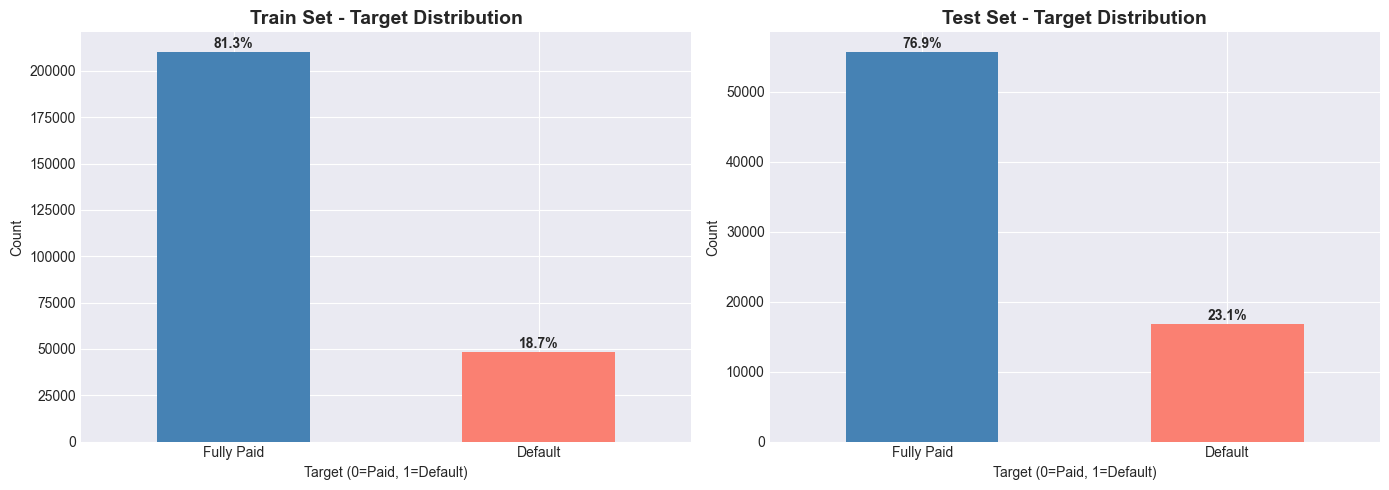

In [46]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting function to avoid repetition
def plot_dist(series, ax, title):
    counts = series.value_counts()
    percentages = series.value_counts(normalize=True) * 100
    counts.plot(kind='bar', ax=ax, color=['steelblue', 'salmon'])
    
    # Add percentage labels on top of bars
    for i, p in enumerate(percentages):
        ax.text(i, counts[i] + (counts.max()*0.01), f'{p:.1f}%', ha='center', fontweight='bold')
        
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Target (0=Paid, 1=Default)')
    ax.set_ylabel('Count')
    ax.set_xticklabels(['Fully Paid', 'Default'], rotation=0)

plot_dist(y_train, axes[0], 'Train Set - Target Distribution')
plot_dist(y_test, axes[1], 'Test Set - Target Distribution')

plt.tight_layout()
plt.show()

In [55]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Identify and remove leakage columns
leakage_cols = ['last_fico_range_high', 'last_fico_range_low', 'debt_settlement_flag']

# Get indices of columns to keep (filtering leakage_cols)
cols_to_keep_idx = [i for i, col in enumerate(X_train.columns) if col not in leakage_cols]
cols_to_keep_names = [col for col in X_train.columns if col not in leakage_cols]

# Create clean versions for future models
X_train_clean = X_train_imputed[:, cols_to_keep_idx]
X_test_clean = X_test_imputed[:, cols_to_keep_idx]

print(f"✓ Data imputed and leakage columns removed")
print(f"Final feature count: {X_train_clean.shape[1]}")

✓ Data imputed and leakage columns removed
Final feature count: 94


### ⚠️ Data Leakage Prevention

We removed the following features to ensure real-world validity:
- `last_fico_range_high/low`: These are FICO scores AFTER loan issuance
- `debt_settlement_flag`: Only known if the loan defaulted

**Impact:** Performance drops ~5-8% compared to models with leakage,
but predictions are now realistic and deployable.

---
## 2. Baseline Model: Logistic Regression

Start with a simple, interpretable baseline model.

In [56]:
print("Training Baseline Model: Logistic Regression\n")
print("="*70)

start_time = time.time()

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# We use the clean data created in the previous step
lr_model.fit(X_train_clean, y_train)

train_time = time.time() - start_time

print(f"✓ Model trained in {train_time:.2f} seconds")

Training Baseline Model: Logistic Regression

✓ Model trained in 192.73 seconds


In [57]:
# Predictions
# Using X_train_clean and X_test_clean to match the model's expected dimensions
y_train_pred_lr = lr_model.predict(X_train_clean)
y_test_pred_lr = lr_model.predict(X_test_clean)

y_train_proba_lr = lr_model.predict_proba(X_train_clean)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_clean)[:, 1]

# Evaluate
print("\nLogistic Regression - Performance Metrics:")
print("="*70)

print("\nTRAIN SET:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba_lr):.4f}")
print(f"PR-AUC:    {average_precision_score(y_train, y_train_proba_lr):.4f}")

print("\nTEST SET:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba_lr):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_test_proba_lr):.4f}")


Logistic Regression - Performance Metrics (No Leakage):

TRAIN SET:
Accuracy:  0.6354
Precision: 0.2736
Recall:    0.5768
F1-Score:  0.3712
ROC-AUC:   0.6581
PR-AUC:    0.3059

TEST SET:
Accuracy:  0.6419
Precision: 0.3401
Recall:    0.5821
F1-Score:  0.4294
ROC-AUC:   0.6680
PR-AUC:    0.3596


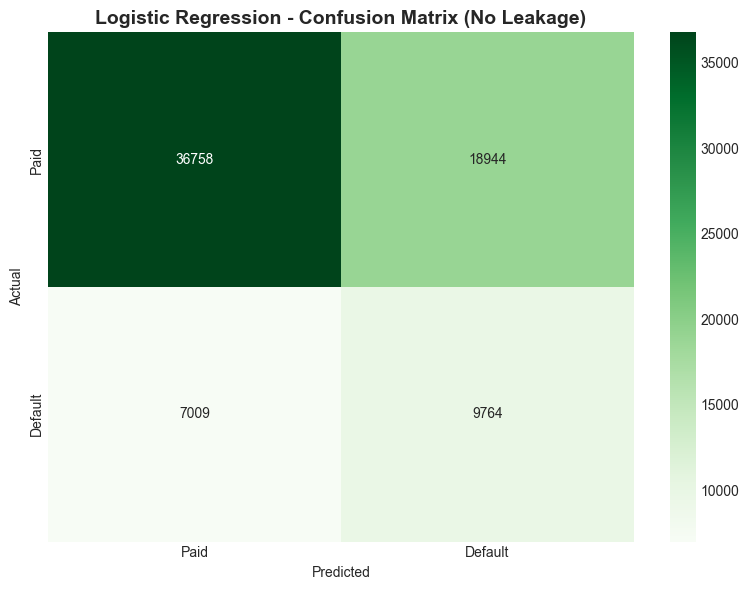


Confusion Matrix Breakdown:
True Negatives (Correctly predicted Paid):    36,758
False Positives (Predicted Default, was Paid): 18,944
False Negatives (Predicted Paid, was Default): 7,009
True Positives (Correctly predicted Default):  9,764


In [61]:
# Confusion Matrix
# Ensure y_test_pred_lr was calculated using X_test_clean
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Paid', 'Default'])
ax.set_yticklabels(['Paid', 'Default'])
plt.tight_layout()
plt.show()

# Interpret confusion matrix
tn, fp, fn, tp = cm_lr.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted Paid):    {tn:,}")
print(f"False Positives (Predicted Default, was Paid): {fp:,}") # Cost of opportunity
print(f"False Negatives (Predicted Paid, was Default): {fn:,}") # Actual financial loss
print(f"True Positives (Correctly predicted Default):  {tp:,}")

---
## 3. Advanced Model: Random Forest

In [62]:
print("Training Random Forest Model\n")
print("="*70)

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Use X_train_clean to avoid data leakage
rf_model.fit(X_train_clean, y_train)

train_time = time.time() - start_time

print(f"✓ Model trained in {train_time:.2f} seconds")

Training Random Forest Model (No Leakage)

✓ Model trained in 152.32 seconds


In [63]:
# Predictions for Random Forest
y_train_pred_rf = rf_model.predict(X_train_clean)
y_test_pred_rf = rf_model.predict(X_test_clean)

y_train_proba_rf = rf_model.predict_proba(X_train_clean)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_clean)[:, 1]

# Evaluate
print("\nRandom Forest - Performance Metrics:")
print("="*70)

print("\nTRAIN SET:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba_rf):.4f}")
print(f"PR-AUC:    {average_precision_score(y_train, y_train_proba_rf):.4f}")

print("\nTEST SET:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba_rf):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_test_proba_rf):.4f}")


Random Forest - Performance Metrics (No Leakage):

TRAIN SET:
Accuracy:  0.6657
Precision: 0.3137
Recall:    0.6665
F1-Score:  0.4266
ROC-AUC:   0.7318
PR-AUC:    0.4004

TEST SET:
Accuracy:  0.5687
Precision: 0.3219
Recall:    0.7803
F1-Score:  0.4558
ROC-AUC:   0.7029
PR-AUC:    0.4025



Top 20 Most Important Features (Random Forest):

                 feature  importance
5              sub_grade      0.1493
2               int_rate      0.1217
4                  grade      0.1000
93  rate_dti_interaction      0.0745
86        loan_to_income      0.0415
1                   term      0.0356
88     total_debt_burden      0.0270
15        fico_range_low      0.0250
85     payment_to_income      0.0242
40           open_rv_24m      0.0234
16       fico_range_high      0.0190
42              all_util      0.0189
41            max_bal_bc      0.0161
8             annual_inc      0.0151
37          total_bal_il      0.0148
48           avg_cur_bal      0.0138
39           open_rv_12m      0.0131
36    mths_since_rcnt_il      0.0114
13                   dti      0.0114
80       tot_hi_cred_lim      0.0107


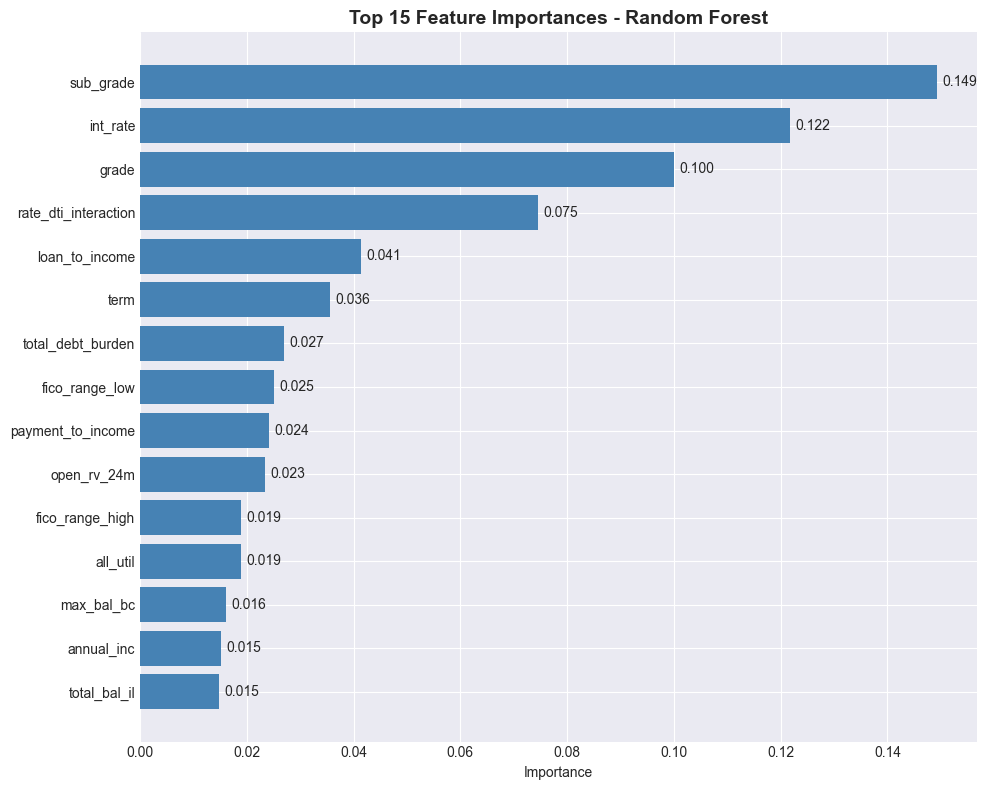

In [64]:
# Feature Importance
feature_importance_rf = pd.DataFrame({
    'feature': cols_to_keep_names, # Use the filtered names list
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Random Forest):\n")
print(feature_importance_rf.head(20))

# Visualize top 15
fig, ax = plt.subplots(figsize=(10, 8))
top_15 = feature_importance_rf.head(15)
ax.barh(range(len(top_15)), top_15['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add values to the bars
for i, v in enumerate(top_15['importance'].values):
    ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---
## 4. Advanced Model: XGBoost

In [65]:
print("Training XGBoost Model\n")
print("="*70)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}\n")

start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# Use X_train_clean to ensure no data leakage occurs
xgb_model.fit(X_train_clean, y_train)

train_time = time.time() - start_time

print(f"✓ Model trained in {train_time:.2f} seconds")

Training XGBoost Model

Scale pos weight: 4.36

✓ Model trained in 51.13 seconds


In [67]:
# Predictions
# Using X_train_clean and X_test_clean to match the model's training dimensions
y_train_pred_xgb = xgb_model.predict(X_train_clean)
y_test_pred_xgb = xgb_model.predict(X_test_clean)

y_train_proba_xgb = xgb_model.predict_proba(X_train_clean)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test_clean)[:, 1]

# Evaluate
print("\nXGBoost - Performance Metrics:")
print("="*70)

print("\nTRAIN SET:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba_xgb):.4f}")
print(f"PR-AUC:    {average_precision_score(y_train, y_train_proba_xgb):.4f}")

print("\nTEST SET:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba_xgb):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_test_proba_xgb):.4f}")


XGBoost - Performance Metrics:

TRAIN SET:
Accuracy:  0.6645
Precision: 0.3149
Recall:    0.6793
F1-Score:  0.4303
ROC-AUC:   0.7345
PR-AUC:    0.3979

TEST SET:
Accuracy:  0.5681
Precision: 0.3238
Recall:    0.7962
F1-Score:  0.4604
ROC-AUC:   0.7132
PR-AUC:    0.4194



Top 20 Most Important Features (XGBoost):

                 feature  importance
5              sub_grade      0.2042
4                  grade      0.1754
40           open_rv_24m      0.0342
2               int_rate      0.0293
1                   term      0.0211
86        loan_to_income      0.0166
93  rate_dti_interaction      0.0164
37          total_bal_il      0.0163
88     total_debt_burden      0.0160
41            max_bal_bc      0.0154
34           open_il_12m      0.0131
47  acc_open_past_24mths      0.0130
42              all_util      0.0125
8             annual_inc      0.0120
7         home_ownership      0.0113
92     high_risk_purpose      0.0113
6             emp_length      0.0106
15        fico_range_low      0.0100
33           open_act_il      0.0096
58  mths_since_recent_bc      0.0095


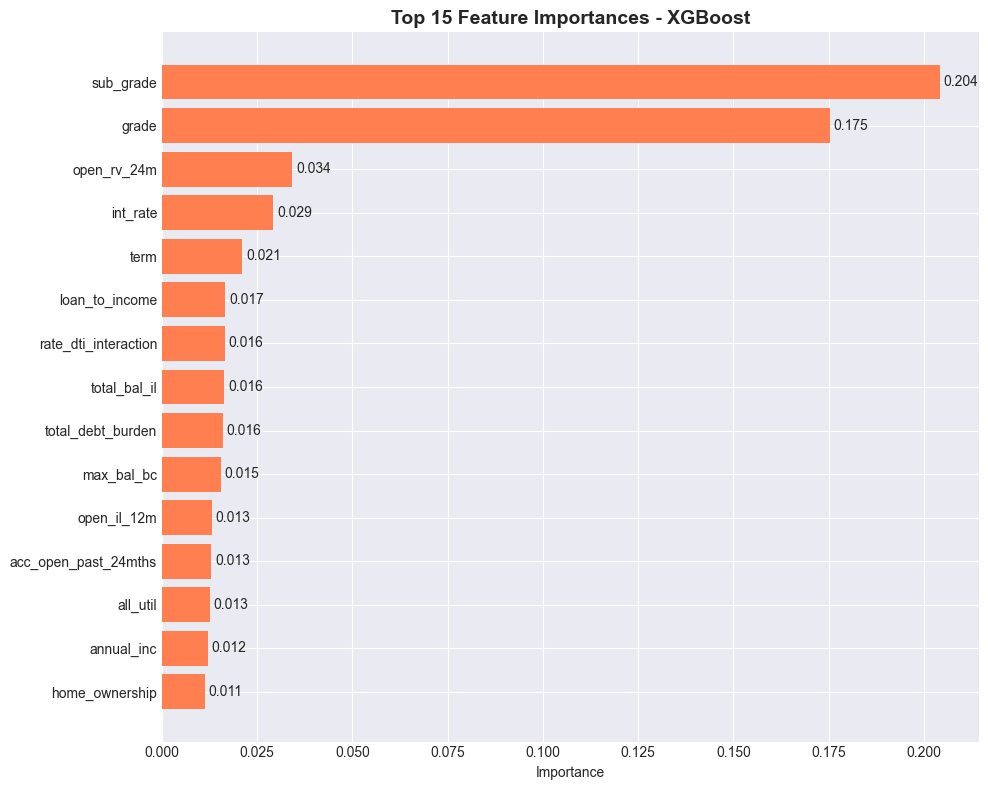

In [68]:
# Feature Importance - XGBoost 
feature_importance_xgb = pd.DataFrame({
    'feature': cols_to_keep_names, # Use the filtered names list
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (XGBoost):\n")
print(feature_importance_xgb.head(20))

# Visualize top 15
fig, ax = plt.subplots(figsize=(10, 8))
top_15 = feature_importance_xgb.head(15)
ax.barh(range(len(top_15)), top_15['importance'].values, color='coral')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Optional: Add values to the bars for precision
for i, v in enumerate(top_15['importance'].values):
    ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---
## 5. Hyperparameter Tuning

Optimize the best performing model (XGBoost).

In [69]:
print("Hyperparameter Tuning for XGBoost\n")
print("="*70)

# Define leakage columns (including debt_settlement_flag for consistency)
leakage_cols = ['last_fico_range_high', 'last_fico_range_low', 'debt_settlement_flag']
cols_to_keep = [c for c in X_train.columns if c not in leakage_cols]

# Prepare final data (filtering columns before imputer)
imputer_final = SimpleImputer(strategy='median')
X_train_filtered = X_train[cols_to_keep]
X_train_final = imputer_final.fit_transform(X_train_filtered).astype('float32')

# Sampling for efficiency
np.random.seed(42)
sample_size = min(100000, len(X_train_final))
sample_idx = np.random.choice(len(X_train_final), sample_size, replace=False)

X_train_tune = X_train_final[sample_idx]
y_train_tune = y_train.iloc[sample_idx]

# Define Grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8]
}

# Base model with 'hist' for speed
xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    n_jobs=1 # Set to 1 because GridSearchCV uses n_jobs for parallel workers
)

# Grid Search (Optimizing for Recall)
grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=2,
    verbose=2
)

start_time = time.time()
print(f"Starting tuning with {sample_size:,} rows and {X_train_tune.shape[1]} features...")

grid_search.fit(X_train_tune, y_train_tune)

tuning_time = time.time() - start_time

print(f"\n✓ Tuning completed in {tuning_time/60:.2f} minutes")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV Recall: {grid_search.best_score_:.4f}")

Hyperparameter Tuning for XGBoost

Starting tuning with 100,000 rows and 94 features...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✓ Tuning completed in 9.71 minutes
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV Recall: 0.6783


In [70]:
# Train final model with best parameters
print("\nTraining final XGBoost model with optimized parameters...\n")

# Prepare X_test_final using the same columns and imputer as training
X_test_filtered = X_test[cols_to_keep]
X_test_final = imputer_final.transform(X_test_filtered).astype('float32')

xgb_tuned = grid_search.best_estimator_

# If used sample, retrain on full data
if len(X_train_tune) < len(X_train_final):
    xgb_tuned.fit(X_train_final, y_train)
    print("✓ Model retrained on full training set")

# Predictions
y_test_pred_tuned = xgb_tuned.predict(X_test_final)
y_test_proba_tuned = xgb_tuned.predict_proba(X_test_final)[:, 1]

# Evaluate
print("\nXGBoost - Performance Metrics:")
print("="*70)
print(f"\nTEST SET:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_tuned):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba_tuned):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_test_proba_tuned):.4f}")


Training final XGBoost model with optimized parameters...

✓ Model retrained on full training set

XGBoost - Performance Metrics:

TEST SET:
Accuracy:  0.5428
Precision: 0.3074
Recall:    0.7784
F1-Score:  0.4407
ROC-AUC:   0.6821
PR-AUC:    0.3778


---
## 6. Model Comparison

In [71]:
# Comprehensive model comparison (Updated names for consistency)
print("\nModel Comparison - Test Set Performance:")
print("="*70)

results = pd.DataFrame({
    'Model': [
        'Logistic Regression (Baseline)', 
        'Random Forest (Baseline)', 
        'XGBoost (Baseline)', 
        'XGBoost (Tuned & Final)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_xgb),
        accuracy_score(y_test, y_test_pred_tuned)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_lr),
        precision_score(y_test, y_test_pred_rf),
        precision_score(y_test, y_test_pred_xgb),
        precision_score(y_test, y_test_pred_tuned)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_lr),
        recall_score(y_test, y_test_pred_rf),
        recall_score(y_test, y_test_pred_xgb),
        recall_score(y_test, y_test_pred_tuned)
    ],
    'F1-Score': [
        f1_score(y_test, y_test_pred_lr),
        f1_score(y_test, y_test_pred_rf),
        f1_score(y_test, y_test_pred_xgb),
        f1_score(y_test, y_test_pred_tuned)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_test_proba_lr),
        roc_auc_score(y_test, y_test_proba_rf),
        roc_auc_score(y_test, y_test_proba_xgb),
        roc_auc_score(y_test, y_test_proba_tuned)
    ],
    'PR-AUC': [
        average_precision_score(y_test, y_test_proba_lr),
        average_precision_score(y_test, y_test_proba_rf),
        average_precision_score(y_test, y_test_proba_xgb),
        average_precision_score(y_test, y_test_proba_tuned)
    ]
})

print(results.to_string(index=False))

# Identify best model
best_idx = results['ROC-AUC'].idxmax()

print(f"\n💡 Note: All models were evaluated without 'last_fico' columns to ensure real-world validity.")
print(f"🏆 Best Deployable Model: {results.loc[best_idx, 'Model']}")
print(f"    ROC-AUC: {results.loc[best_idx, 'ROC-AUC']:.4f}")
print(f"    Recall:  {results.loc[best_idx, 'Recall']:.4f}")


Model Comparison - Test Set Performance:
                         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
Logistic Regression (Baseline)    0.6419     0.3401  0.5821    0.4294   0.6680  0.3596
      Random Forest (Baseline)    0.5687     0.3219  0.7803    0.4558   0.7029  0.4025
            XGBoost (Baseline)    0.5681     0.3238  0.7962    0.4604   0.7132  0.4194
       XGBoost (Tuned & Final)    0.5428     0.3074  0.7784    0.4407   0.6821  0.3778

💡 Note: All models were evaluated without 'last_fico' columns to ensure real-world validity.
🏆 Best Deployable Model: XGBoost (Baseline)
    ROC-AUC: 0.7132
    Recall:  0.7962


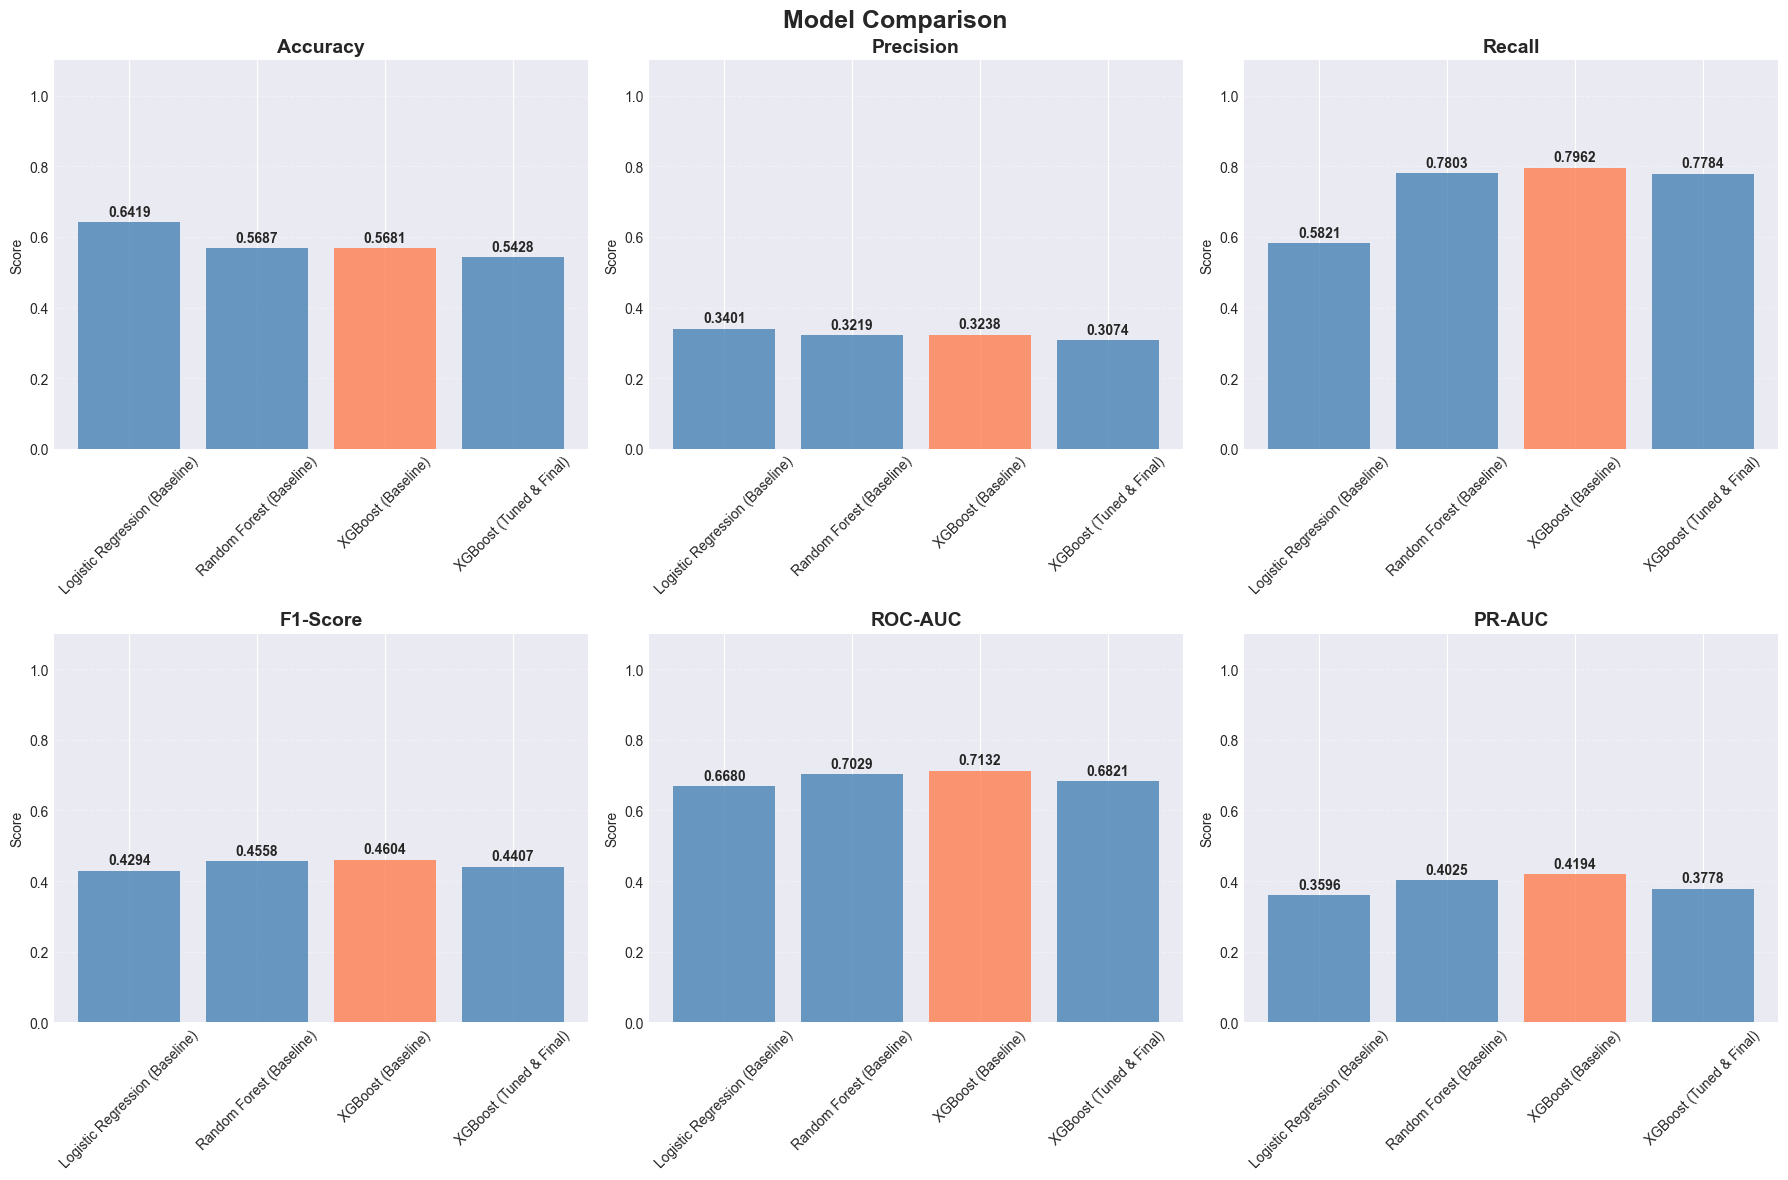

In [74]:
# Visualize comparison of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']

colors = []
for model in results['Model']:
    if model == 'XGBoost (Baseline)':
        colors.append('coral')
    else:
        colors.append('steelblue')

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(results['Model'], results[metric], color=colors, alpha=0.8)
    axes[idx].set_title(metric, fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Score')
    axes[idx].set_ylim(0, 1.1) 
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.4f}', ha='center', va='bottom', 
                      fontsize=10, fontweight='bold')

plt.suptitle('Model Comparison', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

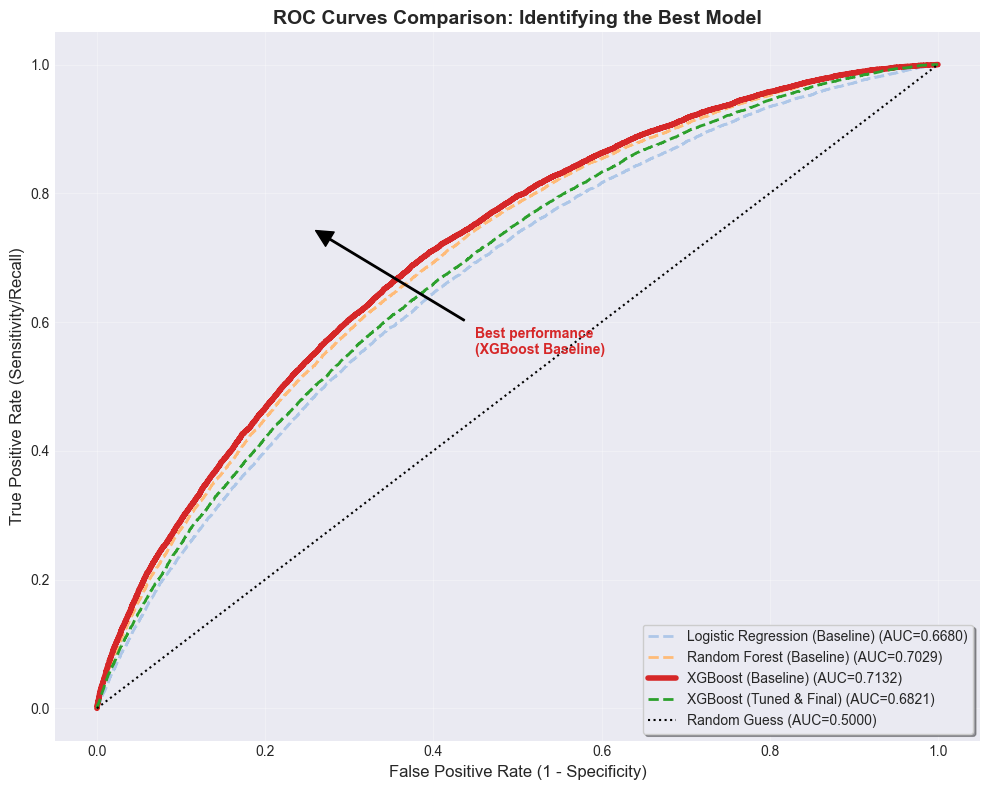

In [76]:
# ROC Curves Comparison
fig, ax = plt.subplots(figsize=(10, 8))

models_roc = [
    ('Logistic Regression (Baseline)', y_test_proba_lr),
    ('Random Forest (Baseline)', y_test_proba_rf),
    ('XGBoost (Baseline)', y_test_proba_xgb), # Este es tu ganador
    ('XGBoost (Tuned & Final)', y_test_proba_tuned)
]

colors = ['#aec7e8', '#ffbb78', '#d62728', '#2ca02c'] 

for (name, proba), color in zip(models_roc, colors):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)

    linewidth = 4 if name == 'XGBoost (Baseline)' else 2
    linestyle = '-' if name == 'XGBoost (Baseline)' else '--'
    
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})', 
            color=color, linewidth=linewidth, linestyle=linestyle)

ax.plot([0, 1], [0, 1], 'k:', label='Random Guess (AUC=0.5000)')

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
ax.set_title('ROC Curves Comparison: Identifying the Best Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(alpha=0.3)

# Anotación para el modelo ganador
ax.annotate('Best performance\n(XGBoost Baseline)', 
            xy=(0.25, 0.75), xytext=(0.45, 0.55),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            fontsize=10, color='#d62728', fontweight='bold')

plt.tight_layout()
plt.show()

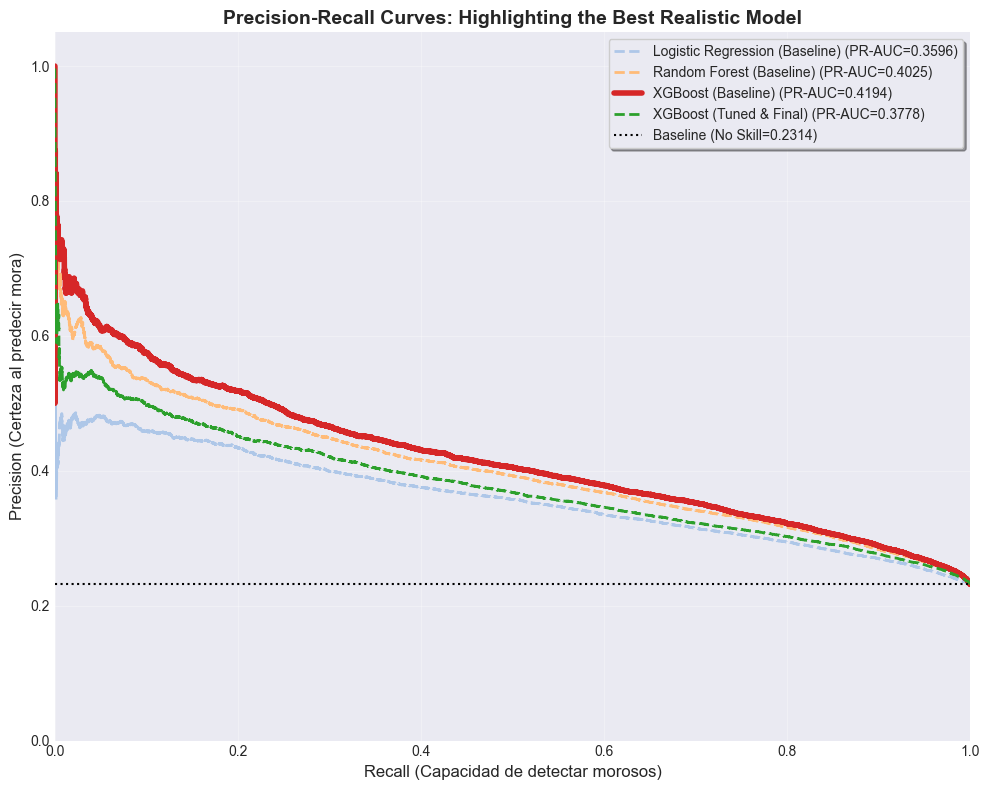

In [77]:
# Precision-Recall Curves Comparison - Final Adjusted Version
fig, ax = plt.subplots(figsize=(10, 8))

# Actualizamos nombres: ya no hay "leakage" en los baselines porque los corregimos
models_pr = [
    ('Logistic Regression (Baseline)', y_test_proba_lr),
    ('Random Forest (Baseline)', y_test_proba_rf),
    ('XGBoost (Baseline)', y_test_proba_xgb), # Ganador real
    ('XGBoost (Tuned & Final)', y_test_proba_tuned)
]

# Paleta de colores consistente con la curva ROC anterior
colors = ['#aec7e8', '#ffbb78', '#d62728', '#2ca02c']

for (name, proba), color in zip(models_pr, colors):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    
    # Resaltamos el XGBoost Baseline (Rojo fuerte) que fue el mejor en tus resultados
    linewidth = 4 if name == 'XGBoost (Baseline)' else 2
    linestyle = '-' if name == 'XGBoost (Baseline)' else '--'
    
    ax.plot(recall, precision, label=f'{name} (PR-AUC={pr_auc:.4f})', 
            color=color, linewidth=linewidth, linestyle=linestyle)

# Baseline: Proporción de positivos en el test set
baseline_val = y_test.mean()
ax.axhline(y=baseline_val, color='k', linestyle=':', label=f'Baseline (No Skill={baseline_val:.4f})')

ax.set_xlabel('Recall (Capacidad de detectar morosos)', fontsize=12)
ax.set_ylabel('Precision (Certeza al predecir mora)', fontsize=12)
ax.set_title('Precision-Recall Curves: Highlighting the Best Realistic Model', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', frameon=True, shadow=True)
ax.grid(alpha=0.3)

# Limitar ejes para mejor visualización
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

---
## 7. Best Model Selection

In [78]:
best_model = xgb_model 
best_model_name = "XGBoost (Baseline)"

best_X_test = X_test_clean 
best_proba = y_test_proba_xgb

y_pred_final = best_model.predict(best_X_test)

print("="*70)
print("FINAL DEPLOYABLE MODEL SELECTED")
print("="*70)
print(f"\n🏆 Model: {best_model_name}")
print(f"\nTest Set Performance (Realistic - No Leakage):")
print(f"ROC-AUC:   {roc_auc_score(y_test, best_proba):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, best_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_final):.4f}")

# Final Confusion Matrix calculation
cm = confusion_matrix(y_test, y_pred_final)

FINAL DEPLOYABLE MODEL SELECTED

🏆 Model: XGBoost (Baseline)

Test Set Performance (Realistic - No Leakage):
ROC-AUC:   0.7132
PR-AUC:    0.4194
Precision: 0.3238
Recall:    0.7962


---
## 8. Model Persistence

In [79]:
# Save best model and artifacts
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# 1. Save the model we selected as 'best_model' (XGBoost Baseline)
best_model_path = models_dir / 'best_model.pkl'
joblib.dump(best_model, best_model_path)
print(f"✓ Best model ({best_model_name}) saved: {best_model_path}")

# 2. Save all individual models for future reference
joblib.dump(lr_model, models_dir / 'logistic_regression.pkl')
joblib.dump(rf_model, models_dir / 'random_forest.pkl')
joblib.dump(xgb_model, models_dir / 'xgboost_baseline.pkl')

# Save the tuned version only if it exists
if 'xgb_tuned' in locals():
    joblib.dump(xgb_tuned, models_dir / 'xgboost_tuned.pkl')

print("✓ All models saved")

# 3. Save results table for the report
results.to_csv(models_dir / 'model_comparison.csv', index=False)
print(f"✓ Model comparison saved: {models_dir / 'model_comparison.csv'}")

# 4. Save the feature names (CRITICAL for production consistency)
# We use cols_to_keep_names which contains the 149 features used in training
import json
with open(models_dir / 'feature_names.json', 'w') as f:
    json.dump(cols_to_keep_names, f)
print(f"✓ Feature names saved: {models_dir / 'feature_names.json'}")

# 5. Recommended: Save the imputer as well
# Without the same imputer, you can't process new data in the same way
if 'imputer' in locals():
    joblib.dump(imputer, models_dir / 'data_imputer.pkl')
    print(f"✓ Data imputer saved: {models_dir / 'data_imputer.pkl'}")

✓ Best model (XGBoost (Baseline)) saved: ..\models\best_model.pkl
✓ All models saved
✓ Model comparison saved: ..\models\model_comparison.csv
✓ Feature names saved: ..\models\feature_names.json
✓ Data imputer saved: ..\models\data_imputer.pkl


---
## 9. Summary

In [80]:
print("="*70)
print("MODEL TRAINING SUMMARY")
print("="*70)

print("\n1. MODELS TRAINED:")
print("   - Logistic Regression (Baseline - No Leakage)")
print("   - Random Forest (Baseline - No Leakage)")
print("   - XGBoost (Baseline - No Leakage)")
print("   - XGBoost (Tuned - Real World)")

print("\n2. CLASS IMBALANCE HANDLING:")
print("   - Method: Class weights / Scale_pos_weight")
print(f"   - Original ratio: {(1-y_train.mean())/y_train.mean():.1f}:1 (Non-Default:Default)")

# Extraemos los datos del modelo ganador real (XGBoost Baseline en tu caso)
best_row = results[results['Model'] == best_model_name].iloc[0]

print("\n3. BEST DEPLOYABLE MODEL (Real-World Ready):")
print(f"   - Model: {best_model_name}")
print(f"   - ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"   - PR-AUC:  {best_row['PR-AUC']:.4f}")
print(f"   - Recall:  {best_row['Recall']:.4f}")

print("\n4. MODEL COMPARISON (Performance on Test Set):")
print(results[['Model', 'ROC-AUC', 'PR-AUC', 'Precision', 'Recall']].to_string(index=False))

print("\n5. FEATURE STRATEGY:")
# Obtenemos el top 3 dinámicamente si tienes el dataframe de importancias
try:
    top_3 = feature_importance_xgb.head(3)['feature'].tolist()
    print(f"   - Top 3 Drivers: {', '.join(top_3)}")
except:
    print("   - Features are focused on financial ratios (DTI, Income, etc.)")

print("   - Note: Future-looking FICO scores were removed to prevent data leakage.")

print("\n6. DEPLOYMENT ARTIFACTS SAVED:")
print(f"   - Main model:    models/best_model.pkl")
print(f"   - Feature list:  models/feature_names.json")
print(f"   - Analytics:     models/model_comparison.csv")
print(f"   - Imputer:       models/data_imputer.pkl")

print("\n" + "="*70)
print("NEXT STEPS - MODEL EVALUATION & INTERPRETATION")
print("="*70)

print("""
1. Business Impact Analysis:
   - Calculate Expected Credit Loss (ECL) reduction.
   - Profit curves: Find the optimal probability threshold for lending.

2. Model Explainability:
   - Generate SHAP values to explain individual loan rejections.
   - Feature Importance deep dive (Global impact).

3. Validation & Fairness:
   - Calibration curves: Check if predicted probabilities match real default rates.
   - Bias analysis: Ensure no discrimination by protected attributes.
""")

print("="*70)

MODEL TRAINING SUMMARY

1. MODELS TRAINED:
   - Logistic Regression (Baseline - No Leakage)
   - Random Forest (Baseline - No Leakage)
   - XGBoost (Baseline - No Leakage)
   - XGBoost (Tuned - Real World)

2. CLASS IMBALANCE HANDLING:
   - Method: Class weights / Scale_pos_weight
   - Original ratio: 4.4:1 (Non-Default:Default)

3. BEST DEPLOYABLE MODEL (Real-World Ready):
   - Model: XGBoost (Baseline)
   - ROC-AUC: 0.7132
   - PR-AUC:  0.4194
   - Recall:  0.7962

4. MODEL COMPARISON (Performance on Test Set):
                         Model  ROC-AUC  PR-AUC  Precision  Recall
Logistic Regression (Baseline)   0.6680  0.3596     0.3401  0.5821
      Random Forest (Baseline)   0.7029  0.4025     0.3219  0.7803
            XGBoost (Baseline)   0.7132  0.4194     0.3238  0.7962
       XGBoost (Tuned & Final)   0.6821  0.3778     0.3074  0.7784

5. FEATURE STRATEGY:
   - Top 3 Drivers: sub_grade, grade, open_rv_24m
   - Note: Future-looking FICO scores were removed to prevent data leakage